# Capstone Project - LSTM Analysis
### DATA 606, Spring 2022, Dr. Chaojie Wang

#### Description: 
This notebook uses the LSTM Machine Learning model to apply to the cleansed summary-level micromobility data generated in the Clean for ML Jupyter notebook.  This notebook will build the LSTM model and attempt to use it to predict micromobility usage in the cities in our analysis.  

#### Dataset Sources: 
<ul>
    <li><b>Micromobility Data Aggregated by Day.</b>  This uses the cleaned pre-grouped dataset generated by the 03 Clean for ML Jupyter Notebook.  This pre-grouped dataset is aggregated by city and by day for the period from January 2017 through December 2021.</li>
    <li><b>Historic Weather Data from NOAA</b> as shown in the 02 EDA Jupyter Notebook. <br />
        Abbreviations for Weather Elements: RCP = Precipitation (tenths of mm); SNWD = Snow depth (mm); TMAX = Maximum temperature; AWND = Avg Wind speed; WSF5 = Max 5 sec Wind gust;   
    </li>
</ul>

## Function Definitions & Setup
This section deals with imports and function definitions

In [1]:
import pandas as pd
pd.__version__

'1.3.4'

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np

In [4]:
import os
from os.path import join, isdir
from os import mkdir, path

In [5]:
import datetime

In [6]:
# Import my helper py file to help with importing the data
import dfimporthelpers as imp

## User Input Parameters
Specify the city for which to run the ARIMA analysis:

In [7]:
city = 'San Francisco'    # Change this to any of these: Chicago, NYC, San Francisco

<br><br>

## Load the prepared micromobility data that is pre-grouped for each city

In [8]:
dir_path = '/Users/DF/Library/CloudStorage/OneDrive-Personal/Documents/' + \
           'Grad School-David’s MacBook Pro/Spring 2022 - Capstone/JupyterNB/'

os.chdir(dir_path)

In [9]:
df = pd.read_csv('nyc_chicago_sf_tripsbydate_2017to2021.csv', low_memory=False, dtype='unicode')

In [10]:
# Set field types
df['start_date'] = pd.to_datetime(df['start_date']) 
df['#trips'] = df['#trips'].astype(int)
df['duration_minutes'] = df['duration_minutes'].astype(float)

In [11]:
df.dtypes

city                        object
start_date          datetime64[ns]
year                        object
month                       object
year-month                  object
#trips                       int64
duration_minutes           float64
dtype: object

<br />

### View the data

In [12]:
df.head()

,city,start_date,year,month,year-month,#trips,duration_minutes
0,Chicago,2017-01-01,2017,1,2017-01,1727,25880.733333
1,Chicago,2017-01-02,2017,1,2017-01,1960,20142.733333
2,Chicago,2017-01-03,2017,1,2017-01,4537,47873.266667
3,Chicago,2017-01-04,2017,1,2017-01,3269,33301.583333
4,Chicago,2017-01-05,2017,1,2017-01,2917,26602.916667


In [13]:
df.isnull().sum()

city                0
start_date          0
year                0
month               0
year-month          0
#trips              0
duration_minutes    0
dtype: int64

In [14]:
df.dtypes

city                        object
start_date          datetime64[ns]
year                        object
month                       object
year-month                  object
#trips                       int64
duration_minutes           float64
dtype: object

In [15]:
# Reduce to only columns that will be used in analysis
df = df[['city','start_date','#trips']]

#### Rename start_date to "DATE" so that it will be the same as the NOAA weather data.
This will make the merged dataframe cleaner

In [16]:
df.rename(columns={'start_date':'DATE'}, inplace=True)

In [17]:
df.head()

,city,DATE,#trips
0,Chicago,2017-01-01,1727
1,Chicago,2017-01-02,1960
2,Chicago,2017-01-03,4537
3,Chicago,2017-01-04,3269
4,Chicago,2017-01-05,2917


<br />

### Load the NOAA Weather Dataset

In [18]:
df_w = pd.read_csv('data/NOAA_WeatherActuals_Chicago_NYC_SF.csv', low_memory=False)

In [19]:
df_w.head(5)

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WSF5,city
0,USW00023234,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",1/1/17,15.43,0.05,NaN,NaN,51,54.0,46.0,35.1,San Francisco
1,USW00023234,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",1/2/17,7.38,0.18,NaN,NaN,47,52.0,44.0,19.9,San Francisco
2,USW00023234,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",1/3/17,16.33,0.64,NaN,NaN,50,59.0,48.0,53.9,San Francisco
3,USW00023234,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",1/4/17,10.74,0.49,NaN,NaN,56,59.0,47.0,40.9,San Francisco
4,USW00023234,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",1/5/17,8.50,0.00,NaN,NaN,48,51.0,41.0,21.9,San Francisco


In [20]:
# Convert date field
df_w['DATE'] = pd.to_datetime(df_w['DATE'])

In [21]:
df_w.isnull().sum()

STATION       0
NAME          0
DATE          0
AWND          0
PRCP          0
SNOW       1826
SNWD       1826
TAVG          0
TMAX         20
TMIN         20
WSF5         26
city          0
dtype: int64

In [22]:
# fill nulls as 0
df_w = df_w.fillna(0)

In [23]:
# limit just to the fields we will use in our analysis
df_w = df_w[['city','DATE','AWND','PRCP','SNWD','TMAX','WSF5']]

In [24]:
df_w.head()

,city,DATE,AWND,PRCP,SNWD,TMAX,WSF5
0,San Francisco,2017-01-01,15.43,0.05,0.0,54.0,35.1
1,San Francisco,2017-01-02,7.38,0.18,0.0,52.0,19.9
2,San Francisco,2017-01-03,16.33,0.64,0.0,59.0,53.9
3,San Francisco,2017-01-04,10.74,0.49,0.0,59.0,40.9
4,San Francisco,2017-01-05,8.50,0.00,0.0,51.0,21.9


<br />

### Join the NOAA Weather Dataset into the Micromobility dataframe

In [25]:
df.dtypes

city              object
DATE      datetime64[ns]
#trips             int64
dtype: object

In [26]:
df_w.dtypes

city            object
DATE    datetime64[ns]
AWND           float64
PRCP           float64
SNWD           float64
TMAX           float64
WSF5           float64
dtype: object

In [27]:
# Filter the dataframe for the user specified city
if city != '':
    df = df[(df['city'] == city)]

In [28]:
df.shape

(1648, 3)

<br />

#### We will join based on city and date fields in each dataframe

In [29]:
df_merged = pd.merge(df, df_w, left_on=['DATE','city'], right_on=['DATE','city'])

In [30]:
df = df_merged
df.head()

,city,DATE,#trips,AWND,PRCP,SNWD,TMAX,WSF5
0,San Francisco,2017-06-28,632,14.54,0.0,0.0,66.0,30.0
1,San Francisco,2017-06-29,1019,16.11,0.0,0.0,66.0,40.0
2,San Francisco,2017-06-30,1038,15.66,0.0,0.0,65.0,36.9
3,San Francisco,2017-07-01,475,16.11,0.0,0.0,66.0,35.1
4,San Francisco,2017-07-02,523,7.61,0.0,0.0,74.0,25.1


In [31]:
df.shape

(1648, 8)

In [32]:
df.head()

,city,DATE,#trips,AWND,PRCP,SNWD,TMAX,WSF5
0,San Francisco,2017-06-28,632,14.54,0.0,0.0,66.0,30.0
1,San Francisco,2017-06-29,1019,16.11,0.0,0.0,66.0,40.0
2,San Francisco,2017-06-30,1038,15.66,0.0,0.0,65.0,36.9
3,San Francisco,2017-07-01,475,16.11,0.0,0.0,66.0,35.1
4,San Francisco,2017-07-02,523,7.61,0.0,0.0,74.0,25.1


In [33]:
df = df.set_index('DATE')

In [34]:
# Drop the city column 
df = df.drop(['city'], axis=1)

In [35]:
df.head()

,#trips,AWND,PRCP,SNWD,TMAX,WSF5
DATE,,,,,,
2017-06-28,632,14.54,0.0,0.0,66.0,30.0
2017-06-29,1019,16.11,0.0,0.0,66.0,40.0
2017-06-30,1038,15.66,0.0,0.0,65.0,36.9
2017-07-01,475,16.11,0.0,0.0,66.0,35.1
2017-07-02,523,7.61,0.0,0.0,74.0,25.1


In [36]:
df.columns[[0]]

Index(['#trips'], dtype='object')

In [37]:
df.shape

(1648, 6)

<br />

## Now run the LSTM model
##### Reference Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

This uses the example from the above referenced source.

In [38]:
# pip install keras
# pip install tensorflow

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)   var2(t)  \
1   0.457380        0.0        0.0   0.634615   0.483871  0.034487  0.511781   
2   0.511781        0.0        0.0   0.634615   0.645161  0.035605  0.496188   
3   0.496188        0.0        0.0   0.625000   0.595161  0.002472  0.511781   
4   0.511781        0.0        0.0   0.634615   0.566129  0.005297  0.217256   
5   0.217256        0.0        0.0   0.711538   0.404839  0.009828  0.271310   

   var3(t)  var4(t)   var5(t)   var6(t)  
1      0.0      0.0  0.634615  0.645161  
2      0.0      0.0  0.625000  0.595161  
3      0.0      0.0  0.634615  0.566129  
4      0.0      0.0  0.711538  0.404839  
5      0.0      0.0  0.759615  0.417742  
(1460, 1, 10) (1460,) (187, 1, 10) (187,)


2022-05-18 16:39:25.406474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
21/21 - 3s - loss: 0.3255 - val_loss: 0.1872 - 3s/epoch - 125ms/step
Epoch 2/50
21/21 - 0s - loss: 0.1313 - val_loss: 0.0833 - 88ms/epoch - 4ms/step
Epoch 3/50
21/21 - 0s - loss: 0.0945 - val_loss: 0.0784 - 100ms/epoch - 5ms/step
Epoch 4/50
21/21 - 0s - loss: 0.0867 - val_loss: 0.0739 - 99ms/epoch - 5ms/step
Epoch 5/50
21/21 - 0s - loss: 0.0837 - val_loss: 0.0714 - 112ms/epoch - 5ms/step
Epoch 6/50
21/21 - 0s - loss: 0.0801 - val_loss: 0.0684 - 97ms/epoch - 5ms/step
Epoch 7/50
21/21 - 0s - loss: 0.0769 - val_loss: 0.0653 - 90ms/epoch - 4ms/step
Epoch 8/50
21/21 - 0s - loss: 0.0738 - val_loss: 0.0631 - 99ms/epoch - 5ms/step
Epoch 9/50
21/21 - 0s - loss: 0.0709 - val_loss: 0.0610 - 100ms/epoch - 5ms/step
Epoch 10/50
21/21 - 0s - loss: 0.0683 - val_loss: 0.0595 - 120ms/epoch - 6ms/step
Epoch 11/50
21/21 - 0s - loss: 0.0661 - val_loss: 0.0582 - 98ms/epoch - 5ms/step
Epoch 12/50
21/21 - 0s - loss: 0.0641 - val_loss: 0.0569 - 110ms/epoch - 5ms/step
Epoch 13/50
21/21 - 0s - loss: 0

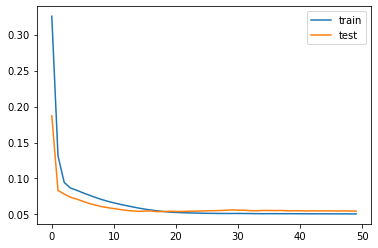

6/6 [==============================] - 0s 3ms/step


In [39]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# Use our dataframe (DRF)
values = df.values


# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# In this case, we will drop the '#Trips' (DRF)
reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values

# We will train on 4 of the 5 years of data (DRF)
n_train_days = 365 * 4
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [40]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [41]:
print(len(train))
print(len(test))

1460
187


### Plot the results

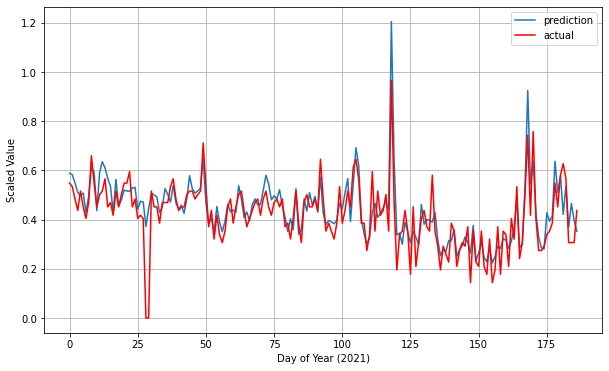

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(inv_yhat,label='prediction')
plt.plot(inv_y,color='red',label='actual')
plt.ylabel('Scaled Value')
plt.xlabel('Day of Year (2021)')
plt.legend()
#plt.tight_layout()
plt.grid()
plt.show()

### Assess performance using the Normalized Root-Mean Squared Error metric
##### Based on: https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa



In [43]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(inv_yhat[-365:], inv_y)/(np.max(inv_y)-np.min(inv_y))
nrmse

0.08011286